<a href="https://colab.research.google.com/github/Rodrigo-Tenorio/2025_THURAM_JAX_tutorial/blob/main/THURAM_JAX_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install jax numpy matplotlib

# JAX Tutorial: Fit a function using `grad`, `vmap`, and `jit`.

JAX is...
- Numpy + GPU + JIT + (Aut. Vectorisation) + (Auto. differentiation)
- [...una anima di pura programmazione funzionale](https://www.sscardapane.it/iaml-backup/jax-intro/)

JAX is not...

- Cupy / Numpy + Numba
- Pytorch / TensorFlow
- Haskell

In short, JAX is a Python library that is [*looks literally like*](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html) `numpy` to the user, but that internally leverages an "intermediate representation" (viz. `pytree`& `jaxpr`) and a compiler (`openXLA`) to deliver efficient implementations adapted to the available hardware.

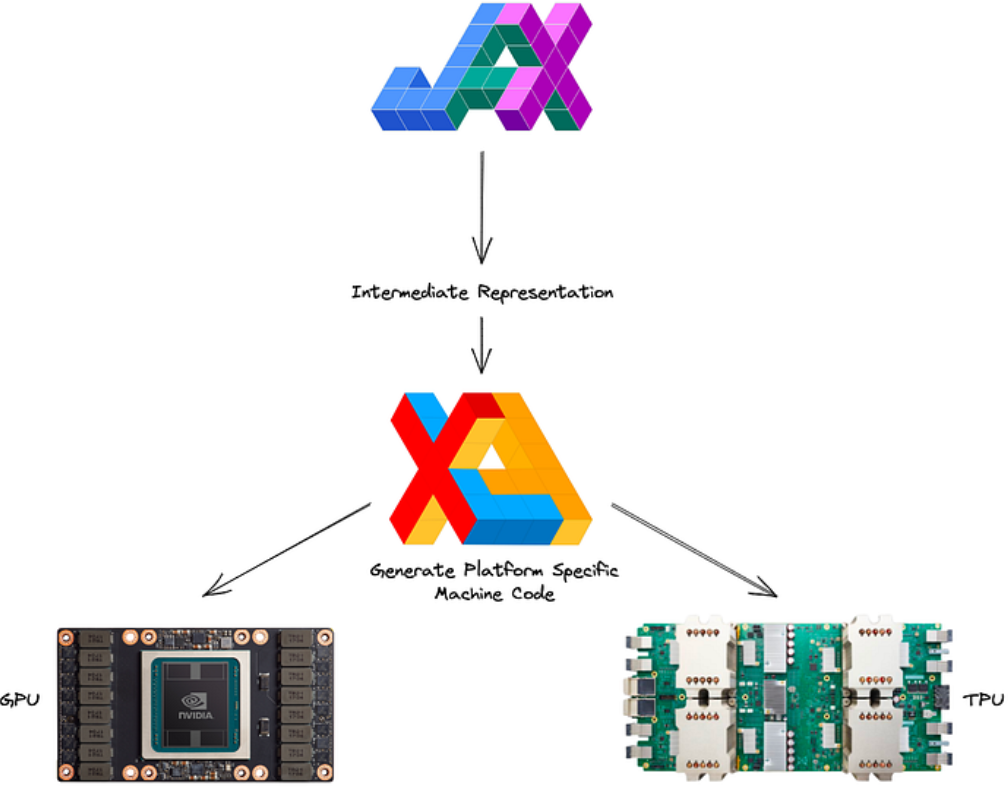
source: https://www.ml6.eu/blogpost/need-for-speed-jax



# JAX is not your friend.  

Read [the sharp bits](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html) and be extremely careful when...
1. Compiling. -> Triggering re-compilation will kill your performance.
2. Timings functions. -> Always beware of asyncronous dispatching and use `jax.block_until_ready`.
3. Timings functions. Read 2. again.
4. Generating random numbers. -> Keys (i.e. "seeds") are tracable and must be split explicitly.
5. Indexing arrays. JAX won't check whether the index is within bounds.

This sounds a lot, but the computing gains are *comparable to writing CUDA code* for a fraction of the development cost.

See [Tenorio+ arxiv:2411.18370, Tenorio & Gerosa 2025 arxiv:2502.11823]

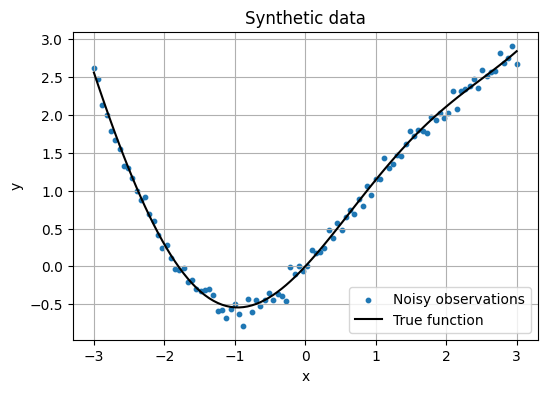

In [ ]:
# JAX Tutorial: Function Fitting with `grad` and `vmap`



# ## Introduction
# We will fit a slightly nonlinear function using a 2-layer perceptron  in JAX.
# We'll compute gradients with `grad`, and vectorize evaluations with `vmap`.

# ---

# ## Imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Set random seed for reproducibility
key = jax.random.PRNGKey(42)

# ---

# ## Step 1: Generate synthetic data
# Let's define a "true" function and generate some noisy data around it.

def true_fn(x):
    return jnp.sin(x) + 0.3 * x**2

x_data = jnp.linspace(-3, 3, 100)
y_true = true_fn(x_data)

# Always split the key to generate random numbers!
key, subkey = jax.random.split(key)
noise = 0.1 * jax.random.normal(subkey, shape=x_data.shape)

y_data = y_true + noise

# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label="Noisy observations", s=10)
plt.plot(x_data, y_true, label="True function", color='black')
plt.legend()
plt.title("Synthetic data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()



In [ ]:
jax.make_jaxpr(true_fn)(x_data)

{ lambda ; a:f32[100]. let
    b:f32[100] = sin a
    c:f32[100] = integer_pow[y=2] a
    d:f32[100] = mul 0.30000001192092896 c
    e:f32[100] = add b d
  in (e,) }

In [ ]:
# ---

# ## Step 2: Define a 2-layer MLP
def mlp(x, params):
    """
    x: float --> Note we write it for 1 input.
    params: dict[str, jax.ndarray]
    """
    h1 = jnp.tanh(x * params['w1'] + params['b1'])
    h2 = jnp.tanh(jnp.dot(h1, params['w2'] + params['b2']))
    return jnp.dot(h2, params['w3'] + params['b3']).squeeze()

def init_params(key, hidden_dim=3):
    k_w1, k_w2, k_w3, k_b1, k_b2, k_b3 = jax.random.split(key, 6)
    return {
        'w1': jax.random.normal(k_w1, (1, hidden_dim)),
        'w2': jax.random.normal(k_w2, (hidden_dim, hidden_dim)),
        'w3': jax.random.normal(k_w3, (hidden_dim, 1)),
        'b1': jax.random.normal(k_b1, (hidden_dim,)),
        'b2': jax.random.normal(k_b2, (hidden_dim,)),
        'b3': jax.random.normal(k_b3, (1,)),
        }

key, subkey = jax.random.split(key)
some_parameters = init_params(subkey)

In [ ]:
mlp(x_data[0], some_parameters)

Array(0.10541046, dtype=float32)

In [ ]:
# How do we tell jax "x will be many numbers?" We vectorise.

vectorised_mlp = jax.vmap(mlp, in_axes=(0, None), out_axes=0)

vectorised_mlp(x_data, some_parameters)

Array([ 0.10541046,  0.10542226,  0.10543501,  0.10544908,  0.1054647 ,
        0.10548174,  0.10550034,  0.10552073,  0.10554326,  0.10556853,
        0.10559571,  0.10562575,  0.10565913,  0.10569644,  0.10573804,
        0.10578382,  0.10583472,  0.10589147,  0.10595453,  0.10602546,
        0.10610497,  0.10619378,  0.10629356,  0.10640633,  0.10653353,
        0.10667765,  0.10684097,  0.10702646,  0.10723853,  0.10748112,
        0.10775936,  0.10807955,  0.10845041,  0.10888028,  0.10938132,
        0.10996759,  0.11065674,  0.11147022,  0.11243558,  0.11358631,
        0.11496413,  0.11662149,  0.11862326,  0.12104893,  0.12399495,
        0.12757647,  0.13192451,  0.1371795 ,  0.14347458,  0.15089703,
        0.15942419,  0.16880047,  0.17834795,  0.18667042,  0.19125223,
        0.18799043,  0.17082238,  0.13180077,  0.06217849, -0.04495108,
       -0.19058317, -0.36589053, -0.5513737 , -0.7210593 , -0.8502689 ,
       -0.9227911 , -0.93427336, -0.89160365, -0.80959845, -0.70

`vmap` is a function transformation that takes an arbitrary function

```
f :: X -> Y
```
and returns a "vectorised" function
```
vmap f :: [X] -> [Y]
```
Now stop for a second and think about how cool this is.

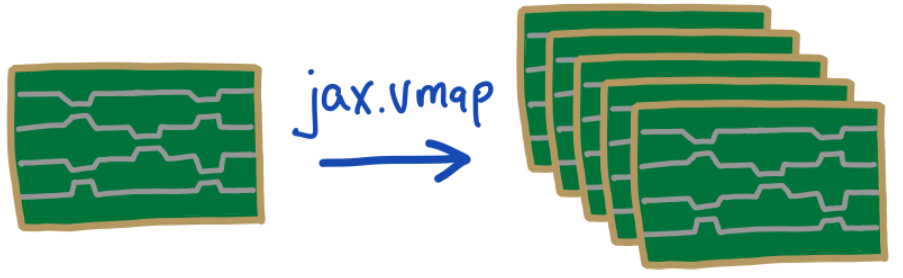

Source: https://pennylane.ai/qml/demos/tutorial_jax_transformations

In [ ]:
# ---

# ## Step 3: Define the loss and compute gradients with `grad`
# We'll use Mean Squared Error (MSE) as the loss function.


# What about the gradient?

JAX implements Automatic Differentiation through `grad`, `jacfwd`, `jaxrev`, `jvp` and so on and so on. We will stick to the simple case.

How does it work?  ... (opinionated answer incoming):

- Forward mode: Think about [dual numbers](https://en.wikipedia.org/wiki/Dual_number).
- Backward mode: [Backprop](https://en.wikipedia.org/wiki/Backpropagation) (a.k.a. chain rule).
- Actual meaning of it: [Elliott arXiv:1804.00746](https://arxiv.org/abs/1804.00746).

Forwad mode vs. Backward mode depend on how many things are being differentiated and *with respect to* how many things we are taking a gradient.

In ML, the second dominates over the first and Bacward mode is king, usually.



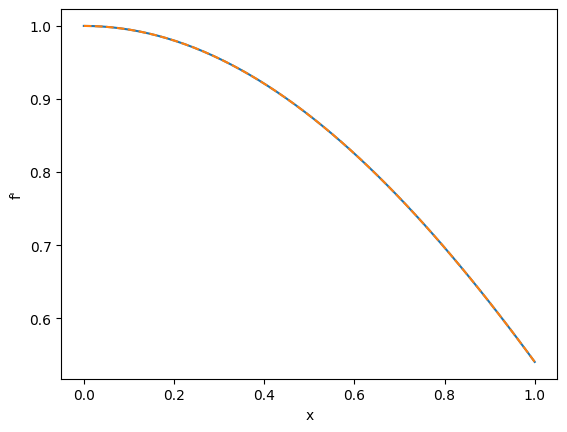

In [ ]:
def f(x):
  return jnp.sin(x)

def f_prime(x):
  return jnp.cos(x)

some_x = jnp.linspace(0, 1)

f_grad = jax.vmap(jax.grad(f), in_axes=0, out_axes=0)(some_x)

fig, ax = plt.subplots()
ax.set(xlabel="x", ylabel="f'")
ax.plot(some_x, f_prime(some_x))
ax.plot(some_x, f_grad, ls="--")

In [ ]:
# ---

# ## Step 4: Training loop using basic SGD

# I paste it again just for the record:
def loss_function(mpl_parameters):
  # `x_data` and `y_data` are passed by clousure, this is fine.
  return (
      (vectorised_mlp(x_data, mpl_parameters) - y_data)**2
      ).mean()

print(f"{loss_function(some_parameters)=}")

loss_function_grad = jax.grad(loss_function)

print("Gradient shapes:")
for label, val in loss_function_grad(some_parameters).items():
  print(label, val.shape)

loss_function(some_parameters)=Array(2.437795, dtype=float32)
Gradient shapes:
b1 (3,)
b2 (3,)
b3 (1,)
w1 (1, 3)
w2 (3, 3)
w3 (3, 1)


Step   0: loss = 2.05718
Step  50: loss = 1.39512
Step 100: loss = 0.96955
Step 150: loss = 0.77048
Step 200: loss = 0.65683
Step 250: loss = 0.55530
Step 300: loss = 0.47285
Step 350: loss = 0.42022
Step 400: loss = 0.38241
Step 450: loss = 0.34617


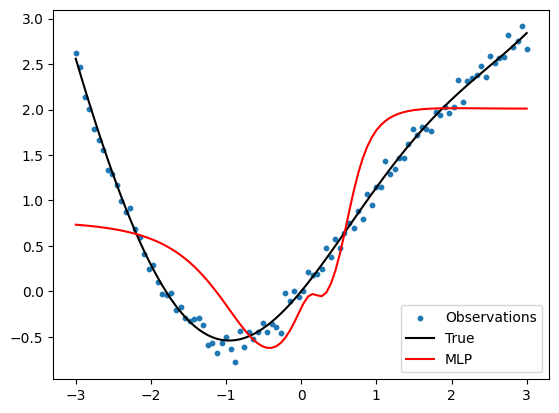

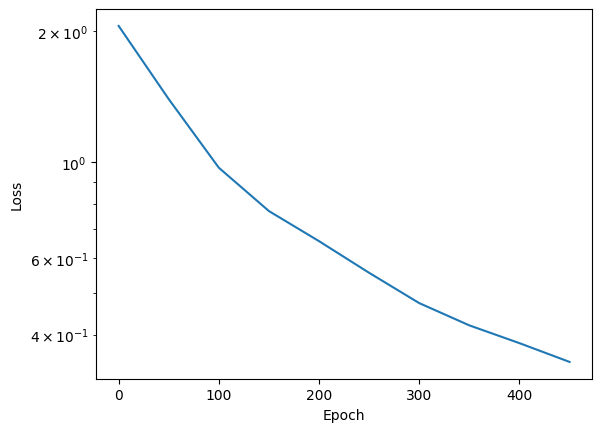

In [ ]:
key, subkey = jax.random.split(key)
params = init_params(key)
learning_rate = 0.01
num_steps = 500

loss_history = []

for step in range(num_steps):
    grads = loss_function_grad(params)
    # This line is `params(n+1) = params(n) - lr * gradient. Trust me.
    params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    if step % 50 == 0:
        loss = loss_function(params)
        loss_history.append(loss)
        print(f"Step {step:3d}: loss = {loss:.5f}")

# ---

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, label="Observations", s=10)
ax.plot(x_data, y_true, label="True", color="black")
ax.plot(x_data, vectorised_mlp(x_data, params), color="red", label="MLP")
ax.legend()

fig, ax = plt.subplots()
ax.set(xlabel="Epoch", ylabel="Loss", yscale="log")
ax.plot(50 * jnp.arange(len(loss_history)), loss_history)

What if we want to train multiple models simultaneously?

Just `vmap`.

In [ ]:
num_networks = 100

vmap_loss = jax.vmap(loss_function, in_axes=0, out_axes=0)

key, *many_keys = jax.random.split(key, num=num_networks + 1)
many_params = jax.vmap(init_params, in_axes=0, out_axes=0)(jnp.array(many_keys))

vmap_loss(many_params)

Array([11.822939  ,  6.061145  ,  2.104995  ,  5.264585  ,  3.5202594 ,
        9.598036  ,  7.086193  ,  8.185632  ,  3.908068  ,  5.3886023 ,
        0.75686294,  1.6071383 ,  6.7166114 ,  2.2580397 ,  4.2888184 ,
        3.4881537 , 11.373049  ,  1.9584686 ,  8.34382   ,  1.6192944 ,
        6.553892  ,  9.334302  ,  6.9518185 ,  3.0756018 , 29.093447  ,
        5.6380515 ,  7.059885  ,  3.481795  ,  5.309667  ,  5.8600736 ,
        5.943151  , 39.503986  ,  4.522847  ,  1.0512257 ,  3.2890031 ,
        1.7331424 ,  1.8847414 ,  6.539636  ,  3.0224602 ,  1.856889  ,
        7.9556236 ,  5.2627697 ,  3.9477718 ,  2.6494024 ,  5.773486  ,
       11.313847  ,  1.7467614 , 15.526462  ,  2.2442005 ,  2.4910119 ,
        5.0090284 ,  2.949073  , 11.454077  ,  3.3236933 ,  1.6442677 ,
        3.8865106 ,  1.811354  ,  1.6075221 ,  2.8435009 , 10.385025  ,
        2.497935  ,  2.1324637 ,  9.78375   ,  5.8153696 ,  3.0398936 ,
        1.9403237 ,  3.2341871 ,  1.0001547 ,  4.0559635 ,  1.54

Is this going to be fast enough...?

In [ ]:
%timeit vmap_loss(many_params).block_until_ready()

6.42 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
fast_vmap_loss = jax.jit(vmap_loss)
fast_vmap_loss(many_params)

Array([11.822939  ,  6.061145  ,  2.104995  ,  5.264585  ,  3.5202594 ,
        9.598036  ,  7.086193  ,  8.185632  ,  3.908068  ,  5.3886023 ,
        0.75686294,  1.6071383 ,  6.7166114 ,  2.2580397 ,  4.2888184 ,
        3.4881537 , 11.373049  ,  1.9584686 ,  8.34382   ,  1.6192944 ,
        6.553892  ,  9.334302  ,  6.9518185 ,  3.0756018 , 29.093447  ,
        5.6380515 ,  7.059885  ,  3.481795  ,  5.309667  ,  5.8600736 ,
        5.943151  , 39.503986  ,  4.522847  ,  1.0512257 ,  3.2890031 ,
        1.7331424 ,  1.8847414 ,  6.539636  ,  3.0224602 ,  1.856889  ,
        7.9556236 ,  5.2627697 ,  3.9477718 ,  2.6494024 ,  5.773486  ,
       11.313847  ,  1.7467614 , 15.526462  ,  2.2442005 ,  2.4910119 ,
        5.0090284 ,  2.949073  , 11.454077  ,  3.3236933 ,  1.6442677 ,
        3.8865106 ,  1.811354  ,  1.6075221 ,  2.8435009 , 10.385025  ,
        2.497935  ,  2.1324637 ,  9.78375   ,  5.8153696 ,  3.0398936 ,
        1.9403237 ,  3.2341871 ,  1.0001547 ,  4.0559635 ,  1.54

In [ ]:
%timeit vmap_loss(many_params).block_until_ready()

7.13 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
learning_rate = 0.01
num_steps = 500
print_every = 50

loss_history = jnp.zeros((num_networks, num_steps // print_every))
many_params = jax.vmap(init_params, in_axes=0, out_axes=0)(jnp.array(many_keys))

def _training_step(ind, carry):
  # Takes 1 set of parameters
  loss_history, params = carry

  grads = loss_function_grad(params)
  params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

  here = ind // print_every

  loss_history = jax.lax.cond(
      (ind % print_every) == 0,
      lambda hist: hist.at[here].set(loss_function(params)),
      lambda hist: hist,
      operand=loss_history,
  )

  return (loss_history, params)

vmap_training_step = jax.vmap(
    _training_step,
    in_axes=(None, (0, 0)),
    out_axes=0
    )

# fori_loop jits the function!
loss_history, many_params = jax.lax.fori_loop(0, num_steps, vmap_training_step, (loss_history, many_params))

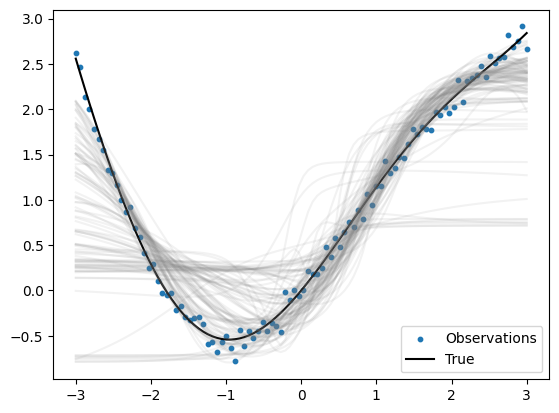

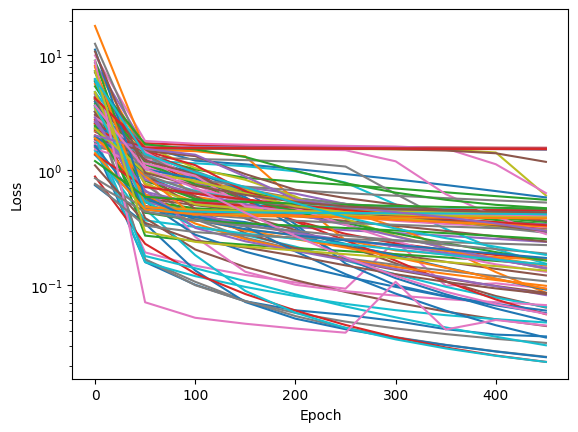

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x_data, y_data, label="Observations", s=10)
ax.plot(x_data, y_true, label="True", color="black")

all_results = jax.vmap(
    vectorised_mlp,
    in_axes=(None, 0),
    out_axes=0
)(x_data, many_params)

ax.plot(x_data, all_results.T, color="gray", alpha=0.1)
ax.legend()

fig, ax = plt.subplots()
ax.set(xlabel="Epoch", ylabel="Loss", yscale="log");
ax.plot(print_every * jnp.arange(loss_history.shape[1]), loss_history.T);